# Supervised Learning in Python 

If you don't have a proper hardware / software configuration you can use Colab: https://colab.research.google.com/notebooks/intro.ipynb?hl=nb

Many libraries are already installed (PyTorch, Tensorflow...)

Libraries we will use throughout these tutorials:
* numpy
* pandas
* matplotlib + seaborn
* scikit-learn
* pytorch + torchvision + tensorboard

## Split dataset

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
x_tosplit = np.arange(1,201,1).reshape(100,2)
y_tosplit = np.random.randint(0,2, (x_tosplit.shape[0]))
print(x_tosplit.shape)
print(y_tosplit.shape)

(100, 2)
(100,)


In [3]:
x_train, x_test, y_train, y_test = train_test_split(
    x_tosplit, y_tosplit, train_size=0.7, shuffle=True, stratify=y_tosplit)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_test)

(70, 2)
(70,)
(30, 2)
(30,)
[[137 138]
 [123 124]
 [ 99 100]
 [147 148]
 [175 176]
 [ 65  66]
 [ 71  72]
 [119 120]
 [141 142]
 [111 112]
 [ 35  36]
 [ 49  50]
 [155 156]
 [ 19  20]
 [105 106]
 [ 31  32]
 [  1   2]
 [135 136]
 [  3   4]
 [ 53  54]
 [195 196]
 [167 168]
 [ 83  84]
 [ 87  88]
 [163 164]
 [ 55  56]
 [ 59  60]
 [ 11  12]
 [ 97  98]
 [129 130]]


## Perceptron

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import pandas as pd

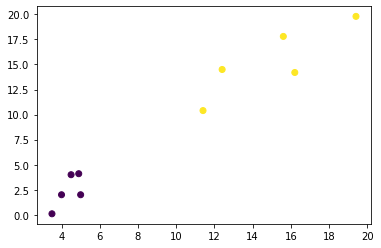

In [10]:
# Read data from file
data = pd.read_csv('perceptron-data.csv')
labels = torch.tensor(data['target'].values, dtype=torch.float32)
data = torch.tensor(data[['x', 'y']].values, dtype=torch.float32)
plt.scatter(data[:, 0], data[:, 1], c=labels)

Last accuracy: 100.0%


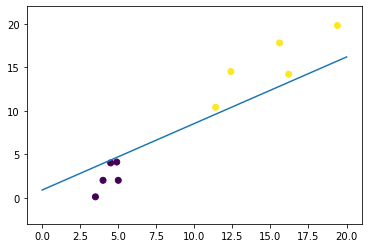

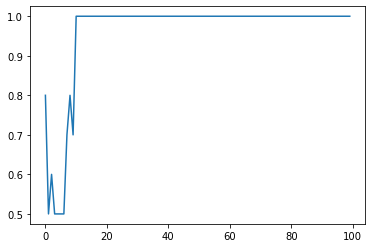

In [11]:
accuracies = []
epochs = 100
eta = 0.1

numpt = data.size(0)
inputDim = data.size(1)

weights = torch.randn(inputDim, dtype=torch.float32, requires_grad=True)
bias = torch.zeros(1, requires_grad=True)

with torch.no_grad():
    for epoch in range(epochs):
        total_accuracy = 0
        
        for idx in range(numpt):
            X = data[idx,:]
            y = labels[idx]
            
            # compute output and loss
            out = torch.add(torch.dot(weights, X), bias).item()
            out = 1 if out > 0 else 0
            if out == y:
                total_accuracy += 1
        
            weights += eta * (y - out) * X
            bias += eta * (y - out)        

        accuracies.append(total_accuracy / float(numpt))

print(f'Last accuracy: {accuracies[-1]*100}%')
# plot points, hyperplane and learning curve
plt.figure()
plt.scatter(data[:,0].numpy(), data[:,1].numpy(), c=labels.numpy())
xr = np.linspace(0, 20, 10)
yr = (-1 / weights[1].item()) * (weights[0].item() * xr  + bias.item())
plt.plot(xr, yr,'-')
plt.xlim(-1, 21)
plt.ylim(-3, 22)
plt.show()

plt.figure()
plt.plot(accuracies, '-')
plt.show()

## Multi Layer Perceptron (a.k.a. feedforward networks)

In [12]:
import torch.nn as nn
import torch.optim as optim

In [13]:
class MLP(nn.Module):
    def __init__(self, layers):

        super(MLP, self).__init__()

        assert len(layers) >= 2, "Layers must specify at least input and output size."

        mlp_layers = []
        for i in range(1, len(layers)):
            mlp_layers.append(nn.Linear(layers[i-1], layers[i], bias=True))
            mlp_layers.append(nn.ReLU())

        self.model = nn.Sequential(*mlp_layers)

    def forward(self, x):
        out = self.model(x)
        return out

In [23]:
# Read data from file
data = pd.read_csv('perceptron-data_notsep.csv')
labels = torch.tensor(data['target'].values).long() # transform labels from {-1, 1} to {0, 1}
data = torch.tensor(data[['x', 'y']].values, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(data, labels)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True, drop_last=True)
numpt = data.size(0)
inputDim = data.size(1)


Last accuracy: 100.0%


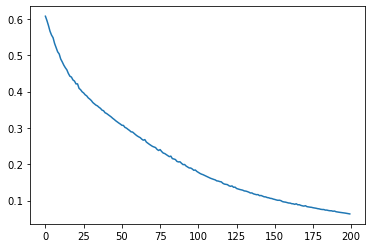

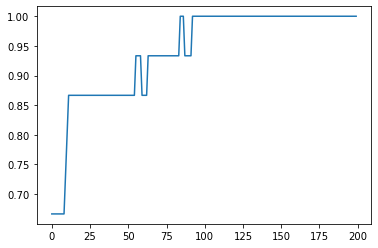

In [28]:
mlp = MLP([inputDim, 64, 2])
optimizer = optim.Adam(mlp.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
epochs = 200

losses = []
accuracies = []
for epoch in range(epochs):
    total_loss, total_accuracy = 0, 0
    for x,y in dataloader:        
        optimizer.zero_grad()
        out = mlp(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            accuracy = (out.argmax(dim=1) == y).sum() / float(y.numel())
        total_loss += loss.item()
        total_accuracy += accuracy.item()
    losses.append(total_loss / float(len(dataloader)))
    accuracies.append(total_accuracy / float(len(dataloader)))


print(f"Last accuracy: {accuracies[-1]*100}%")
plt.figure()
plt.plot(losses, '-')
plt.show()
plt.figure()
plt.plot(accuracies, '-')
plt.show()

## Some popular metrics (and combinations of them)

In [54]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, \
    precision_recall_curve, plot_precision_recall_curve
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

In [91]:
X, y = make_classification(n_classes=2, n_informative=6)
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
model = LogisticRegression().fit(x_train, y_train)
predictions = model.predict(x_test)

In [81]:
# F1
f1_score(y_test, predictions, average='macro')

0.7664071190211346

In [82]:
# Confusion matrix
confusion_matrix(y_test, predictions, normalize='all')

array([[0.36666667, 0.06666667],
       [0.16666667, 0.4       ]])

In [96]:
# P-R curve
probs = model.decision_function(x_test)
p, r, t = precision_recall_curve(y_test, probs)
print(p)
print(r)
print(t)

[0.62068966 0.60714286 0.62962963 0.65384615 0.68       0.70833333
 0.73913043 0.77272727 0.80952381 0.8        0.78947368 0.83333333
 0.82352941 0.875      0.86666667 0.85714286 0.84615385 0.83333333
 0.90909091 0.9        0.88888889 0.875      0.85714286 0.83333333
 0.8        1.         1.         1.         1.         1.        ]
[1.         0.94444444 0.94444444 0.94444444 0.94444444 0.94444444
 0.94444444 0.94444444 0.94444444 0.88888889 0.83333333 0.83333333
 0.77777778 0.77777778 0.72222222 0.66666667 0.61111111 0.55555556
 0.55555556 0.5        0.44444444 0.38888889 0.33333333 0.27777778
 0.22222222 0.22222222 0.16666667 0.11111111 0.05555556 0.        ]
[-7.32722682 -7.1009425  -6.75489521 -6.61346794 -4.52552975 -3.73713754
 -3.25254294 -3.04341487 -3.04071235 -2.90821987 -2.68430114 -2.22608686
 -1.68586855 -1.31789835 -1.21968028 -1.06291346 -0.6812365  -0.28127974
  0.36869757  0.51592492  0.59068665  2.1348874   2.53482593  2.61099999
  2.82052395  3.59442252  3.8807311 

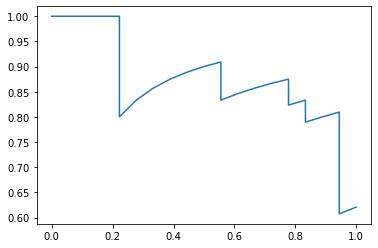

In [97]:
plt.plot(r,p)
plt.show()

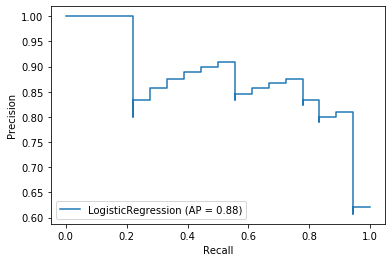

In [94]:
plot_precision_recall_curve(model, x_test, y_test)

In [2]:
# what about ROC curve? Try it out!

## What is tensorboard?

Why tensorboard? Well... when you cannot debug normally...

but also for visualization :)

In [98]:
from torch.utils.tensorboard import SummaryWriter

In [99]:
# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

In [100]:
!ls runs

Nov01_19-26-22_andrea-hp  Nov14_12-48-17_andrea-hp


In [101]:
for i in range(20):
    writer.add_scalar('loss', i,i)

In [102]:
for i in range(20):
    writer.add_scalar('loss', i*i,i)

set x axis to step, otherwise you align results according to execution time

In [103]:
for i in range(100):
    writer.add_scalars('functions', {'xsinx':i,
                                    'xcosx':i**2,
                                    'tanx': np.log(i+1)
    }, i)